<a href="https://colab.research.google.com/github/Beytullah-1001/Deep-Learning-Fundamentals/blob/main/MNIST_Dataset_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Required Libraries

In [ ]:
import torch
import numpy as np
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load Dataset

After we import our required libraries in order to load our dataset properly 

In [ ]:
from ctypes import resize
transform = transforms.Compose([#Our transform object includes ToTensor and Normalizing tranformations 
                               transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset=datasets.MNIST(root='./data',train=True,transform=transform,download=True)#We created our training dataset with transform object. Aditionally we gave our path to keep our data as first parameter.We set up download as true that we can download our training images
validation_dataset=datasets.MNIST(root='./data',train=False,transform=transform,download=True)

validation_loader=torch.utils.data.DataLoader(dataset=validation_dataset,batch_size=100,shuffle=False)#We dont need to shuffle our dataset at every batch..Because validation dataset is not used for training opeartions
training_loader=torch.utils.data.DataLoader(dataset=training_dataset,batch_size=100,shuffle=True)#Training loader object 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def convert_image(tensor):
  image = tensor.clone().detach().numpy()#We convert our tensor to numpy array
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))#We denormalize our image
  image = image.clip(0, 1)# We ensure that our image values  between 0 and 1 because of normalization 
  return image

# Showing Up Training Data

torch.Size([100, 1, 28, 28])


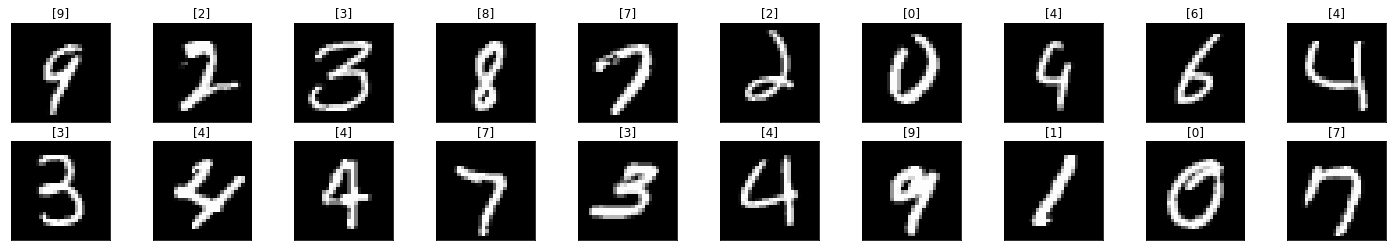

In [ ]:
dataiter = iter(training_loader)
val_dataiter=iter(validation_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
print(images.shape)
for idx in np.arange(20):#We'd like to show 20 training images in our dataset
  #In every iteration we'll add a suplot consists of 2 row and 10 columns.Image will be located in idx+1 value.
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert_image(images[idx]))#To show image we'll use imshow method.But this method takes image as numpy array. So we converted image with convert_image method that we created before
  ax.set_title([labels[idx].item()])#we're setting title as our label values


# 3 Layered Artifical Neural Network

In [ ]:
class Classifier(torch.nn.Module):
  def __init__(self,input_layer,hidden_layer1,hidden_layer2,output_layer):
    super().__init__()
    self.linear1=torch.nn.Linear(input_layer,hidden_layer1)
    self.linear2=torch.nn.Linear(hidden_layer1,hidden_layer2)
    self.linear3=torch.nn.Linear(hidden_layer2,output_layer)

  def forward(self,x):
    x=F.relu(self.linear1(x))
    x=F.relu(self.linear2(x))
    x=self.linear3(x)
    return x


In [ ]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=torch.nn.Conv2d(1,20,5,1)
    self.conv2=torch.nn.Conv2d(20,50,5,1)
    self.fully_connected1=torch.nn.Linear()
    self.fully_connected2=torch.nn.Linear()


We've created our deep neural network above.Our model takes 4 parameters in constructor.<br>
<b><i>input_layer:</i></b>Input layer basically is total number of pixels our image.It has <b>Relu</b> activation Function<br>
<b><i>hidden_layer1:</i></b>Our first linear hidden layer.It has <b>Relu</b> activation function<br>
<b><i>hidden_layer2:</i></b>Our second linear hidden layer.It has <b>Relu</b> activation function<br>
<b><i>output layer:</i></b>Our first linear hidden layer.

In [ ]:
model=Classifier(784,125,65,10)#Our images have 28x28=784 pixels.So we give that as first parameter our classifier.
#Hidden layer1 includes 125 nodes in it.
#Hidden layer2 includes 65 nodes in it.
#We have 10 possible results like 1,2,3,4....10. So we must give 10 for last parameter of our model.
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [ ]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)#Adam Optmizer

# Training

In [ ]:
epochs=12
loss_history=[]
val_loss_history=[]
running_corrects_history=[]
running_loss_history=[]
running_val_corrects_history=[]
running_val_loss_history=[]

for epoch in range(epochs):
  running_loss=0.0
  running_corrects=0.0
  running_val_loss=0.0
  running_val_corrects=0.0

  for inputs,labels in training_loader:
    inputs=inputs.view(inputs.shape[0],-1)
    output=model.forward(inputs)
    loss=criterion(output,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss)

    _,preds=torch.max(output,1)
    running_loss+=loss.item()
    running_corrects+=torch.sum(preds==labels.data)

  else:
    with torch.no_grad():
      for inputs,labels in validation_loader:
        inputs=inputs.view(inputs.shape[0],-1)
        output=model.forward(inputs)
        val_loss=criterion(output,labels)
        
        _,val_preds=torch.max(output,1)
        running_val_loss+=val_loss.item()
        running_val_corrects+=torch.sum(val_preds==labels.data)



      epoch_loss=running_loss/len(training_loader)
      epoch_acc=running_corrects/len(training_loader)
      epoch_validation_loss=running_val_loss/len(validation_loader)
      epoch_validation_acc=running_val_corrects/len(validation_loader)
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_acc)
      running_val_loss_history.append(epoch_validation_loss)
      running_val_corrects_history.append(epoch_validation_acc)
      print("Training loss: {:.4f} Training Accuracy:{:.4f}".format(epoch_loss,epoch_acc))
      print("Validation loss: {:.4f} Validation Accuracy:{:.4f}".format(epoch_validation_loss,epoch_validation_acc))
      





Training loss: 0.9647 Training Accuracy:76.7767
Validation loss: 0.4374 Validation Accuracy:88.2400
Training loss: 0.3881 Training Accuracy:89.1683
Validation loss: 0.3274 Validation Accuracy:90.8600
Training loss: 0.3257 Training Accuracy:90.6517
Validation loss: 0.2967 Validation Accuracy:91.5000
Training loss: 0.2946 Training Accuracy:91.4650
Validation loss: 0.2716 Validation Accuracy:92.3400
Training loss: 0.2704 Training Accuracy:92.1417
Validation loss: 0.2502 Validation Accuracy:92.8000
Training loss: 0.2499 Training Accuracy:92.7767
Validation loss: 0.2365 Validation Accuracy:92.9700
Training loss: 0.2320 Training Accuracy:93.2467
Validation loss: 0.2196 Validation Accuracy:93.6200
Training loss: 0.2149 Training Accuracy:93.8417
Validation loss: 0.2039 Validation Accuracy:93.9300
Training loss: 0.1993 Training Accuracy:94.2483
Validation loss: 0.1900 Validation Accuracy:94.4300
Training loss: 0.1848 Training Accuracy:94.6800
Validation loss: 0.1802 Validation Accuracy:94.7700


# Training Results 

### Training And Validation Losses

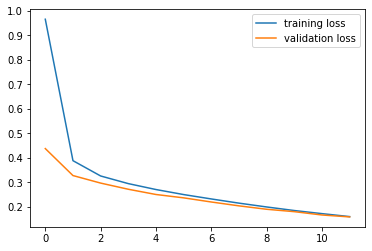

In [ ]:
plt.plot(running_loss_history,label="training loss")
plt.plot(running_val_loss_history,label="validation loss")
plt.legend()

### Training And Validation Accuracies

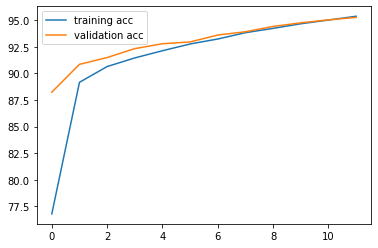

In [ ]:
plt.plot(running_corrects_history,label="training acc")
plt.plot(running_val_corrects_history,label="validation acc")
plt.legend()

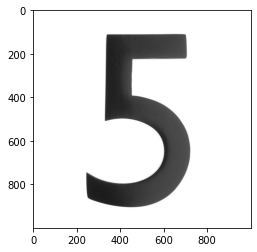

In [ ]:
%matplotlib inline
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread("/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000 (1).jpg")
plt.imshow(img)
plt.show()